## Training for Synth Paper 2022

### Loading data

In [1]:
import os
import glob
from pathlib import Path
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import numpy as np
import timm

import albumentations as albu
from sklearn.metrics import classification_report,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# helper function for data visualization
def visualize(label, **images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        #plt.title(' '.join(name.split('_')).title())
        plt.title(f'{name.title()} | GT: {label}')
        plt.imshow(image)
    plt.show()

### Data Preparation

In [4]:
df = pd.read_csv('synth_paper_data.csv')
#df['class'] = df['class'].astype('category')

In [5]:
df.sample(5)

,file_path,file_name,source,split,class,label_encoded
26427,../../data/Covidx/data_with_classes/train/norm...,6c1c37f8-f8b4-4412-8dd3-9173e9f264ba.png,Covidx,train,H,3
1493,../../data/generated_data/cs_uu/nb/sample_367.png,sample_367.png,Synth,train,H,3
16370,../../data/generated_data/cs_uu/covid/sample_8...,sample_8654.png,Synth,train,C,1
34488,../../data/Covidx/data_with_classes/train/norm...,731074a1-40f5-43cf-ad03-8c69bfbc1636.png,Covidx,train,H,3
28448,../../data/Covidx/data_with_classes/train/norm...,c05d778f-0ba9-4825-94f4-27fdab33a4e6.png,Covidx,train,H,3


In [6]:
df['source'].unique()

array(['UKU_old_split', 'UKU_all', 'Synth', 'Covidx'], dtype=object)

In [7]:
df.loc[df['source']=='UKU_all','class'].value_counts()

H    673
F    125
C    110
B    100
V     74
Name: class, dtype: int64

In [8]:
pd.pivot_table(df.loc[df['source']=='UKU_all'],values=['file_name'],index=['split'],columns=['class'],aggfunc='count')

file_name                  
class         B   C    F    H   V
split                            
test         20  22   25  135  15
train        80  88  100  538  59

In [9]:
df_uku_binary = df.loc[(df['source']=='UKU_all') & (df['class'].isin(['C','H']))].copy()

In [10]:
df_uku_binary['class'] = df_uku_binary['class'].astype('category')
df_uku_binary['label_encoded'] = df_uku_binary['class'].cat.codes.astype('int64')

In [11]:
df_uku_binary['class'].value_counts()

H    673
C    110
Name: class, dtype: int64

In [12]:
pd.pivot_table(df_uku_binary,values=['file_name'],index=['split'],columns=['class'],aggfunc='count')

file_name     
class         C    H
split               
test         22  135
train        88  538

In [13]:
df_uku_binary.head()

,file_path,file_name,source,split,class,label_encoded
333,../../data/segmentation_test/raw/C59.png,C59.png,UKU_all,train,C,0
334,../../data/segmentation_test/raw/NB46.png,NB46.png,UKU_all,train,H,1
335,../../data/segmentation_test/raw/NB663.png,NB663.png,UKU_all,train,H,1
337,../../data/segmentation_test/raw/NB626.png,NB626.png,UKU_all,train,H,1
339,../../data/segmentation_test/raw/NB696.png,NB696.png,UKU_all,train,H,1


Dataloader:

In [14]:
class Dataset(BaseDataset):
    """Read images, apply augmentation and preprocessing transformations."""
    
    def __init__(
            self,
            df, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.df = df.reset_index(drop=True)
        self.ids = self.df.loc[:,'file_path'].values
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.ids[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)   
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image)
            image = sample['image']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image)
            image = sample['image']
        
        label = self.df.loc[i,'label_encoded']
        
        return image, label
        
    def __len__(self):
        return len(self.ids)

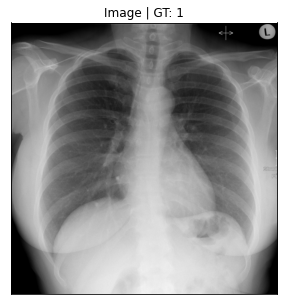

In [15]:
dataset = Dataset(df_uku_binary)

image, label = dataset[3] # get some sample
visualize(
    label=label,
    image=image
)

### Augmentations

In [16]:
image_size = 224

In [17]:
def get_training_augmentation():
    train_transform = [
        
        albu.RandomResizedCrop(height=image_size, width=image_size, scale=(0.25, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=1, p=1.0),
        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        #albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        #albu.RandomCrop(height=320, width=320, always_apply=True),


        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightnessContrast(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.Sharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomBrightnessContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        #albu.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        #albu.PadIfNeeded(384, 480)
        albu.Resize(image_size, image_size),
        #albu.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing():
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD,max_pixel_value=255.0),
        albu.Lambda(image=to_tensor),
    ]
    return albu.Compose(_transform)

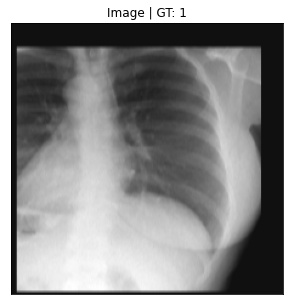

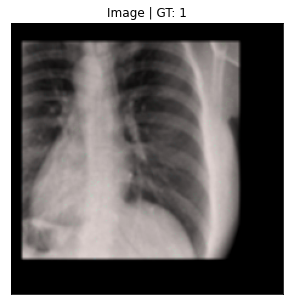

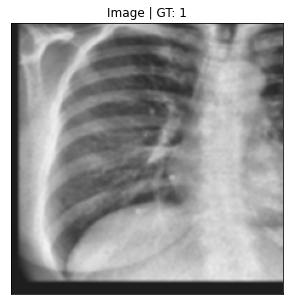

In [18]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    df_uku_binary, 
    augmentation=get_training_augmentation(), 
)

# same image with different random transforms
for i in range(3):
    image, label = augmented_dataset[3]
    visualize(label=label,image=image)

### Create model and train

Define model

In [19]:
dropout = False
dropout_percent = 0.5
num_classes = 2

In [20]:
model = timm.create_model('resnet50', pretrained=True, num_classes=num_classes)
num_ftrs = model.get_classifier().in_features
if dropout:
    model.fc = nn.Sequential(
                            nn.Dropout(dropout_percent),
                            nn.Linear(num_ftrs,num_classes)
    )
else:
    model.fc = nn.Linear(num_ftrs, num_classes)

model = model.to(device) 

Define Loss function and optimizer

In [21]:
epochs = 40
val_loss_min = np.Inf

In [22]:
criterion = nn.CrossEntropyLoss()

In [23]:
optimizer = optim.Adam(model.parameters(),lr=0.0001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs-1)

scaler = torch.cuda.amp.GradScaler()

In [24]:
train_dataset = Dataset(
    df_uku_binary.loc[df_uku_binary['split']=='train',:],
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing()
)

valid_dataset = Dataset(
    df_uku_binary.loc[df_uku_binary['split']=='test',:], 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(),
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

In [25]:
ckpt_dir = './models'
CHECKPOINT = f'{ckpt_dir}/resnet50_synth_uku_all_binary_CvsH.pth'

In [26]:
for epoch in range(epochs):
    model.train()
    train_loss = []
    train_running_corrects = 0
    val_running_corrects = 0
    
    loop = tqdm(train_loader)
    for images, labels in loop:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            train_loss.append(loss.item())
            
            _, predicted = torch.max(outputs.data, 1)
            #_,labels = torch.max(labels.data, 1)
            train_running_corrects += torch.sum(predicted == labels.data)
            
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        scheduler.step()

        loop.set_description('Epoch {:02d}/{:02d} | LR: {:.5f}'.format(epoch, epochs-1, optimizer.param_groups[0]['lr']))
        loop.set_postfix(loss=np.mean(train_loss))

    train_loss = np.mean(train_loss)
    train_epoch_acc = train_running_corrects.double() / len(train_loader.dataset)
    
    model.eval()

    val_loss = 0

    for images, labels in tqdm(valid_loader):
        images = images.to(device)
        labels = labels.to(device)

        with torch.cuda.amp.autocast(), torch.no_grad():
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            #_,labels = torch.max(labels.data, 1)
            val_running_corrects += torch.sum(predicted == labels.data)

    val_loss /= len(valid_loader.dataset)
    val_epoch_acc = val_running_corrects.double() / len(valid_loader.dataset)
    
    print(f'train loss: {train_loss:.5f} | train acc: {train_epoch_acc:.3f} | val_loss: {val_loss:.5f} | val acc: {val_epoch_acc:.3f}')
    
    if val_loss < val_loss_min:
            print(f'Valid loss improved from {val_loss_min:.5f} to {val_loss:.5f} saving model to {CHECKPOINT}')
            val_loss_min = val_loss
            best_epoch = epoch
            torch.save(model.state_dict(), CHECKPOINT)
    
    print(f'Best epoch {best_epoch} | val loss min: {val_loss_min:.5f}')

Epoch 00/39 | LR: 0.00000: 100%|██████████| 40/40 [00:09<00:00,  4.19it/s, loss=0.354]
100%|██████████| 157/157 [00:04<00:00, 33.47it/s]


train loss: 0.35419 | train acc: 0.856 | val_loss: 0.27436 | val acc: 0.860
Valid loss improved from inf to 0.27436 saving model to ./models/resnet50_synth_uku_all_binary_CvsH.pth
Best epoch 0 | val loss min: 0.27436


Epoch 01/39 | LR: 0.00010: 100%|██████████| 40/40 [00:09<00:00,  4.35it/s, loss=0.262]
100%|██████████| 157/157 [00:04<00:00, 33.63it/s]


train loss: 0.26229 | train acc: 0.871 | val_loss: 0.18076 | val acc: 0.898
Valid loss improved from 0.27436 to 0.18076 saving model to ./models/resnet50_synth_uku_all_binary_CvsH.pth
Best epoch 1 | val loss min: 0.18076


Epoch 02/39 | LR: 0.00000: 100%|██████████| 40/40 [00:09<00:00,  4.37it/s, loss=0.204]
100%|██████████| 157/157 [00:04<00:00, 33.56it/s]


train loss: 0.20429 | train acc: 0.922 | val_loss: 0.13240 | val acc: 0.955
Valid loss improved from 0.18076 to 0.13240 saving model to ./models/resnet50_synth_uku_all_binary_CvsH.pth
Best epoch 2 | val loss min: 0.13240


Epoch 03/39 | LR: 0.00010: 100%|██████████| 40/40 [00:09<00:00,  4.18it/s, loss=0.212]
100%|██████████| 157/157 [00:04<00:00, 33.40it/s]


train loss: 0.21205 | train acc: 0.928 | val_loss: 0.10723 | val acc: 0.987
Valid loss improved from 0.13240 to 0.10723 saving model to ./models/resnet50_synth_uku_all_binary_CvsH.pth
Best epoch 3 | val loss min: 0.10723


Epoch 04/39 | LR: 0.00000: 100%|██████████| 40/40 [00:08<00:00,  4.79it/s, loss=0.23] 
100%|██████████| 157/157 [00:04<00:00, 33.24it/s]


train loss: 0.22981 | train acc: 0.939 | val_loss: 0.10286 | val acc: 0.968
Valid loss improved from 0.10723 to 0.10286 saving model to ./models/resnet50_synth_uku_all_binary_CvsH.pth
Best epoch 4 | val loss min: 0.10286


Epoch 05/39 | LR: 0.00009: 100%|██████████| 40/40 [00:08<00:00,  4.58it/s, loss=0.184]
100%|██████████| 157/157 [00:04<00:00, 33.77it/s]


train loss: 0.18368 | train acc: 0.935 | val_loss: 0.06701 | val acc: 0.981
Valid loss improved from 0.10286 to 0.06701 saving model to ./models/resnet50_synth_uku_all_binary_CvsH.pth
Best epoch 5 | val loss min: 0.06701


Epoch 06/39 | LR: 0.00001: 100%|██████████| 40/40 [00:09<00:00,  4.40it/s, loss=0.154]
100%|██████████| 157/157 [00:04<00:00, 33.58it/s]


train loss: 0.15351 | train acc: 0.949 | val_loss: 0.07166 | val acc: 0.981
Best epoch 5 | val loss min: 0.06701


Epoch 07/39 | LR: 0.00009: 100%|██████████| 40/40 [00:09<00:00,  4.34it/s, loss=0.14] 
100%|██████████| 157/157 [00:04<00:00, 33.02it/s]


train loss: 0.13996 | train acc: 0.950 | val_loss: 0.05251 | val acc: 0.987
Valid loss improved from 0.06701 to 0.05251 saving model to ./models/resnet50_synth_uku_all_binary_CvsH.pth
Best epoch 7 | val loss min: 0.05251


Epoch 08/39 | LR: 0.00001: 100%|██████████| 40/40 [00:08<00:00,  4.49it/s, loss=0.15] 
100%|██████████| 157/157 [00:04<00:00, 33.73it/s]


train loss: 0.15020 | train acc: 0.947 | val_loss: 0.05063 | val acc: 0.987
Valid loss improved from 0.05251 to 0.05063 saving model to ./models/resnet50_synth_uku_all_binary_CvsH.pth
Best epoch 8 | val loss min: 0.05063


Epoch 09/39 | LR: 0.00008: 100%|██████████| 40/40 [00:08<00:00,  4.47it/s, loss=0.155]
100%|██████████| 157/157 [00:04<00:00, 33.25it/s]


train loss: 0.15481 | train acc: 0.952 | val_loss: 0.06106 | val acc: 0.987
Best epoch 8 | val loss min: 0.05063


Epoch 10/39 | LR: 0.00002: 100%|██████████| 40/40 [00:08<00:00,  4.59it/s, loss=0.149]
100%|██████████| 157/157 [00:04<00:00, 33.10it/s]


train loss: 0.14912 | train acc: 0.954 | val_loss: 0.06963 | val acc: 0.987
Best epoch 8 | val loss min: 0.05063


Epoch 11/39 | LR: 0.00008: 100%|██████████| 40/40 [00:09<00:00,  4.39it/s, loss=0.141]
100%|██████████| 157/157 [00:04<00:00, 33.18it/s]


train loss: 0.14093 | train acc: 0.957 | val_loss: 0.12323 | val acc: 0.962
Best epoch 8 | val loss min: 0.05063


Epoch 12/39 | LR: 0.00003: 100%|██████████| 40/40 [00:08<00:00,  4.53it/s, loss=0.128]
100%|██████████| 157/157 [00:04<00:00, 33.42it/s]


train loss: 0.12782 | train acc: 0.952 | val_loss: 0.08089 | val acc: 0.975
Best epoch 8 | val loss min: 0.05063


Epoch 13/39 | LR: 0.00007: 100%|██████████| 40/40 [00:09<00:00,  4.35it/s, loss=0.133] 
100%|██████████| 157/157 [00:04<00:00, 32.82it/s]


train loss: 0.13347 | train acc: 0.963 | val_loss: 0.07649 | val acc: 0.981
Best epoch 8 | val loss min: 0.05063


Epoch 14/39 | LR: 0.00003: 100%|██████████| 40/40 [00:09<00:00,  4.27it/s, loss=0.131] 
100%|██████████| 157/157 [00:04<00:00, 33.07it/s]


train loss: 0.13131 | train acc: 0.955 | val_loss: 0.04232 | val acc: 0.987
Valid loss improved from 0.05063 to 0.04232 saving model to ./models/resnet50_synth_uku_all_binary_CvsH.pth
Best epoch 14 | val loss min: 0.04232


Epoch 15/39 | LR: 0.00006: 100%|██████████| 40/40 [00:09<00:00,  4.40it/s, loss=0.123] 
100%|██████████| 157/157 [00:04<00:00, 32.43it/s]


train loss: 0.12255 | train acc: 0.957 | val_loss: 0.04894 | val acc: 0.987
Best epoch 14 | val loss min: 0.04232


Epoch 16/39 | LR: 0.00004: 100%|██████████| 40/40 [00:09<00:00,  4.07it/s, loss=0.137] 
100%|██████████| 157/157 [00:04<00:00, 32.62it/s]


train loss: 0.13730 | train acc: 0.971 | val_loss: 0.04426 | val acc: 0.987
Best epoch 14 | val loss min: 0.04232


Epoch 17/39 | LR: 0.00006: 100%|██████████| 40/40 [00:09<00:00,  4.02it/s, loss=0.0948]
100%|██████████| 157/157 [00:04<00:00, 33.32it/s]


train loss: 0.09478 | train acc: 0.968 | val_loss: 0.07405 | val acc: 0.975
Best epoch 14 | val loss min: 0.04232


Epoch 18/39 | LR: 0.00005: 100%|██████████| 40/40 [00:09<00:00,  4.41it/s, loss=0.12] 
100%|██████████| 157/157 [00:04<00:00, 32.95it/s]


train loss: 0.12005 | train acc: 0.963 | val_loss: 0.03060 | val acc: 0.987
Valid loss improved from 0.04232 to 0.03060 saving model to ./models/resnet50_synth_uku_all_binary_CvsH.pth
Best epoch 18 | val loss min: 0.03060


Epoch 19/39 | LR: 0.00005: 100%|██████████| 40/40 [00:09<00:00,  4.37it/s, loss=0.133]
100%|██████████| 157/157 [00:04<00:00, 33.21it/s]


train loss: 0.13263 | train acc: 0.946 | val_loss: 1.06216 | val acc: 0.580
Best epoch 18 | val loss min: 0.03060


Epoch 20/39 | LR: 0.00006: 100%|██████████| 40/40 [00:08<00:00,  4.51it/s, loss=0.101] 
100%|██████████| 157/157 [00:04<00:00, 32.96it/s]


train loss: 0.10061 | train acc: 0.963 | val_loss: 0.02569 | val acc: 0.994
Valid loss improved from 0.03060 to 0.02569 saving model to ./models/resnet50_synth_uku_all_binary_CvsH.pth
Best epoch 20 | val loss min: 0.02569


Epoch 21/39 | LR: 0.00004: 100%|██████████| 40/40 [00:09<00:00,  4.35it/s, loss=0.126]
100%|██████████| 157/157 [00:04<00:00, 32.43it/s]


train loss: 0.12624 | train acc: 0.962 | val_loss: 0.05550 | val acc: 0.987
Best epoch 20 | val loss min: 0.02569


Epoch 22/39 | LR: 0.00006: 100%|██████████| 40/40 [00:08<00:00,  4.48it/s, loss=0.108] 
100%|██████████| 157/157 [00:04<00:00, 33.40it/s]


train loss: 0.10780 | train acc: 0.968 | val_loss: 0.03356 | val acc: 0.994
Best epoch 20 | val loss min: 0.02569


Epoch 23/39 | LR: 0.00003: 100%|██████████| 40/40 [00:08<00:00,  4.52it/s, loss=0.156] 
100%|██████████| 157/157 [00:04<00:00, 33.40it/s]


train loss: 0.15587 | train acc: 0.947 | val_loss: 0.08795 | val acc: 0.975
Best epoch 20 | val loss min: 0.02569


Epoch 24/39 | LR: 0.00007: 100%|██████████| 40/40 [00:09<00:00,  4.36it/s, loss=0.104] 
100%|██████████| 157/157 [00:04<00:00, 33.19it/s]


train loss: 0.10449 | train acc: 0.954 | val_loss: 0.04578 | val acc: 0.981
Best epoch 20 | val loss min: 0.02569


Epoch 25/39 | LR: 0.00003: 100%|██████████| 40/40 [00:09<00:00,  4.44it/s, loss=0.122] 
100%|██████████| 157/157 [00:04<00:00, 33.73it/s]


train loss: 0.12226 | train acc: 0.955 | val_loss: 0.05100 | val acc: 0.981
Best epoch 20 | val loss min: 0.02569


Epoch 26/39 | LR: 0.00008: 100%|██████████| 40/40 [00:09<00:00,  4.42it/s, loss=0.107] 
100%|██████████| 157/157 [00:04<00:00, 33.43it/s]


train loss: 0.10711 | train acc: 0.963 | val_loss: 0.05851 | val acc: 0.981
Best epoch 20 | val loss min: 0.02569


Epoch 27/39 | LR: 0.00002: 100%|██████████| 40/40 [00:08<00:00,  4.98it/s, loss=0.104] 
100%|██████████| 157/157 [00:04<00:00, 33.87it/s]


train loss: 0.10394 | train acc: 0.971 | val_loss: 0.02675 | val acc: 0.987
Best epoch 20 | val loss min: 0.02569


Epoch 28/39 | LR: 0.00008: 100%|██████████| 40/40 [00:09<00:00,  4.15it/s, loss=0.0879]
100%|██████████| 157/157 [00:04<00:00, 33.40it/s]


train loss: 0.08795 | train acc: 0.970 | val_loss: 0.08576 | val acc: 0.975
Best epoch 20 | val loss min: 0.02569


Epoch 29/39 | LR: 0.00001: 100%|██████████| 40/40 [00:09<00:00,  4.22it/s, loss=0.096] 
100%|██████████| 157/157 [00:04<00:00, 33.90it/s]


train loss: 0.09595 | train acc: 0.963 | val_loss: 0.07201 | val acc: 0.975
Best epoch 20 | val loss min: 0.02569


Epoch 30/39 | LR: 0.00009: 100%|██████████| 40/40 [00:09<00:00,  4.35it/s, loss=0.104] 
100%|██████████| 157/157 [00:04<00:00, 33.69it/s]


train loss: 0.10422 | train acc: 0.971 | val_loss: 0.03647 | val acc: 0.987
Best epoch 20 | val loss min: 0.02569


Epoch 31/39 | LR: 0.00001: 100%|██████████| 40/40 [00:08<00:00,  4.57it/s, loss=0.215] 
100%|██████████| 157/157 [00:04<00:00, 33.72it/s]


train loss: 0.21478 | train acc: 0.952 | val_loss: 0.05876 | val acc: 0.987
Best epoch 20 | val loss min: 0.02569


Epoch 32/39 | LR: 0.00009: 100%|██████████| 40/40 [00:09<00:00,  4.31it/s, loss=0.0898]
100%|██████████| 157/157 [00:04<00:00, 33.91it/s]


train loss: 0.08982 | train acc: 0.965 | val_loss: 0.04483 | val acc: 0.987
Best epoch 20 | val loss min: 0.02569


Epoch 33/39 | LR: 0.00000: 100%|██████████| 40/40 [00:08<00:00,  4.51it/s, loss=0.0738]
100%|██████████| 157/157 [00:04<00:00, 33.81it/s]


train loss: 0.07383 | train acc: 0.971 | val_loss: 0.05526 | val acc: 0.987
Best epoch 20 | val loss min: 0.02569


Epoch 34/39 | LR: 0.00010: 100%|██████████| 40/40 [00:08<00:00,  4.53it/s, loss=0.0793]
100%|██████████| 157/157 [00:04<00:00, 33.84it/s]


train loss: 0.07926 | train acc: 0.970 | val_loss: 0.04856 | val acc: 0.994
Best epoch 20 | val loss min: 0.02569


Epoch 35/39 | LR: 0.00000: 100%|██████████| 40/40 [00:08<00:00,  4.88it/s, loss=0.0822]
100%|██████████| 157/157 [00:04<00:00, 33.76it/s]


train loss: 0.08219 | train acc: 0.971 | val_loss: 0.01541 | val acc: 1.000
Valid loss improved from 0.02569 to 0.01541 saving model to ./models/resnet50_synth_uku_all_binary_CvsH.pth
Best epoch 35 | val loss min: 0.01541


Epoch 36/39 | LR: 0.00010: 100%|██████████| 40/40 [00:09<00:00,  4.42it/s, loss=0.0834]
100%|██████████| 157/157 [00:04<00:00, 33.89it/s]


train loss: 0.08342 | train acc: 0.970 | val_loss: 0.05477 | val acc: 0.994
Best epoch 35 | val loss min: 0.01541


Epoch 37/39 | LR: 0.00000: 100%|██████████| 40/40 [00:08<00:00,  4.45it/s, loss=0.0835]
100%|██████████| 157/157 [00:04<00:00, 33.91it/s]


train loss: 0.08345 | train acc: 0.976 | val_loss: 0.02329 | val acc: 0.987
Best epoch 35 | val loss min: 0.01541


Epoch 38/39 | LR: 0.00010: 100%|██████████| 40/40 [00:09<00:00,  4.35it/s, loss=0.0583]
100%|██████████| 157/157 [00:04<00:00, 33.89it/s]


train loss: 0.05826 | train acc: 0.986 | val_loss: 0.04084 | val acc: 0.987
Best epoch 35 | val loss min: 0.01541


Epoch 39/39 | LR: 0.00000: 100%|██████████| 40/40 [00:09<00:00,  4.32it/s, loss=0.129]
100%|██████████| 157/157 [00:04<00:00, 33.75it/s]

train loss: 0.12862 | train acc: 0.954 | val_loss: 0.03456 | val acc: 0.994
Best epoch 35 | val loss min: 0.01541


### Visualize predictions

In [27]:
model_inf = timm.create_model('resnet50', pretrained=True, num_classes=num_classes)
num_ftrs = model_inf.get_classifier().in_features
if dropout:
    model_inf.fc = nn.Sequential(
                            nn.Dropout(dropout_percent),
                            nn.Linear(num_ftrs,num_classes)
    )
else:
    model_inf.fc = nn.Linear(num_ftrs, num_classes)

model_inf.load_state_dict(torch.load(CHECKPOINT))
model_inf.to(device) 
model_inf = model_inf.eval()

In [28]:
valid_dataset = Dataset(
    df_uku_binary.loc[df_uku_binary['split']=='test',:], 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(),
)

#### Validation data

In [29]:
# For confusion matrix
label_array = np.array([], dtype='int64')
prediction_array = np.array([], dtype='int64')

In [30]:
with torch.no_grad():
    model_inf.eval()
    for images, labels in valid_dataset:
        images = torch.from_numpy(images).to(device).unsqueeze(0)
        #labels = labels.to(device)
        
        cls_outputs = model_inf(images)
        _, predicted = torch.max(cls_outputs.data, 1)
        #_,labels = torch.max(labels.data, 0)
        label_array = np.append(label_array, labels)
        prediction_array = np.append(prediction_array, predicted.detach().cpu().numpy())

In [31]:
%matplotlib inline

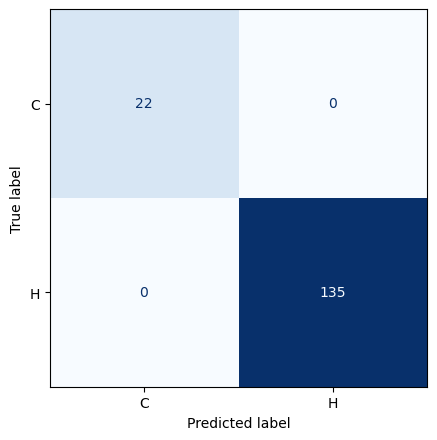

In [33]:
fig, ax = plt.subplots(figsize=(8,5),dpi=100)
ConfusionMatrixDisplay.from_predictions(label_array,prediction_array,display_labels=df_uku_binary['class'].cat.categories,cmap='Blues',colorbar=False,ax=ax)
plt.show()

In [34]:
print(classification_report(label_array, prediction_array, digits=4,target_names=df_uku_binary['class'].cat.categories))

              precision    recall  f1-score   support

           C     1.0000    1.0000    1.0000        22
           H     1.0000    1.0000    1.0000       135

    accuracy                         1.0000       157
   macro avg     1.0000    1.0000    1.0000       157
weighted avg     1.0000    1.0000    1.0000       157

